In [65]:
%pylab notebook
import os, sys

sys.path.append('/Users/alexisdevitre/Documents/code/hts-irradiation/')

import hts_fitting as hts, hts_showcase as sc, hts_dosecalculations as dose
import pandas as pd
from scipy.interpolate import interp1d
from scipy import constants as cst

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [46]:
def estimate_step_dose(data, t0, t1, t2, t3, to1, to2, vb=False):
    offset = data[(to1 <= data.time_s) & (data.time_s <= to2)].ibeam_nA.mean()
    
    d = data[((t0 <= data.time_s) & (data.time_s < t1)) | ((t2 <= data.time_s) & (data.time_s < t3))]
    x = np.arange(d.time_s.min(), d.time_s.max(), .1)
    y = interp1d(d.time_s, d.ibeam_nA)(x)-offset
    
    if vb:
        fig, ax = plt.subplots()
        ax.plot(x, y, marker='o', linestyle='None', label='0.1 s Interpolation')
        ax.plot(d.time_s, d.ibeam_nA, marker='+', color='k', label='Measured')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Beam current on sample [nA]')
        ax.legend(loc='best')
        ax.set_ylim(0, np.max([y.max(), d.ibeam_nA.max()]))
        ax.set_xlim(t0, t3)
        fig.tight_layout()
    c2f = 1e-9/(cst.elementary_charge*cst.pi*(3.175e-3/2)**2)
    return c2f*np.trapz(y, dx=.1), y[(t1 <= x)&(x <= t2)].mean()

<IPython.core.display.Javascript object>


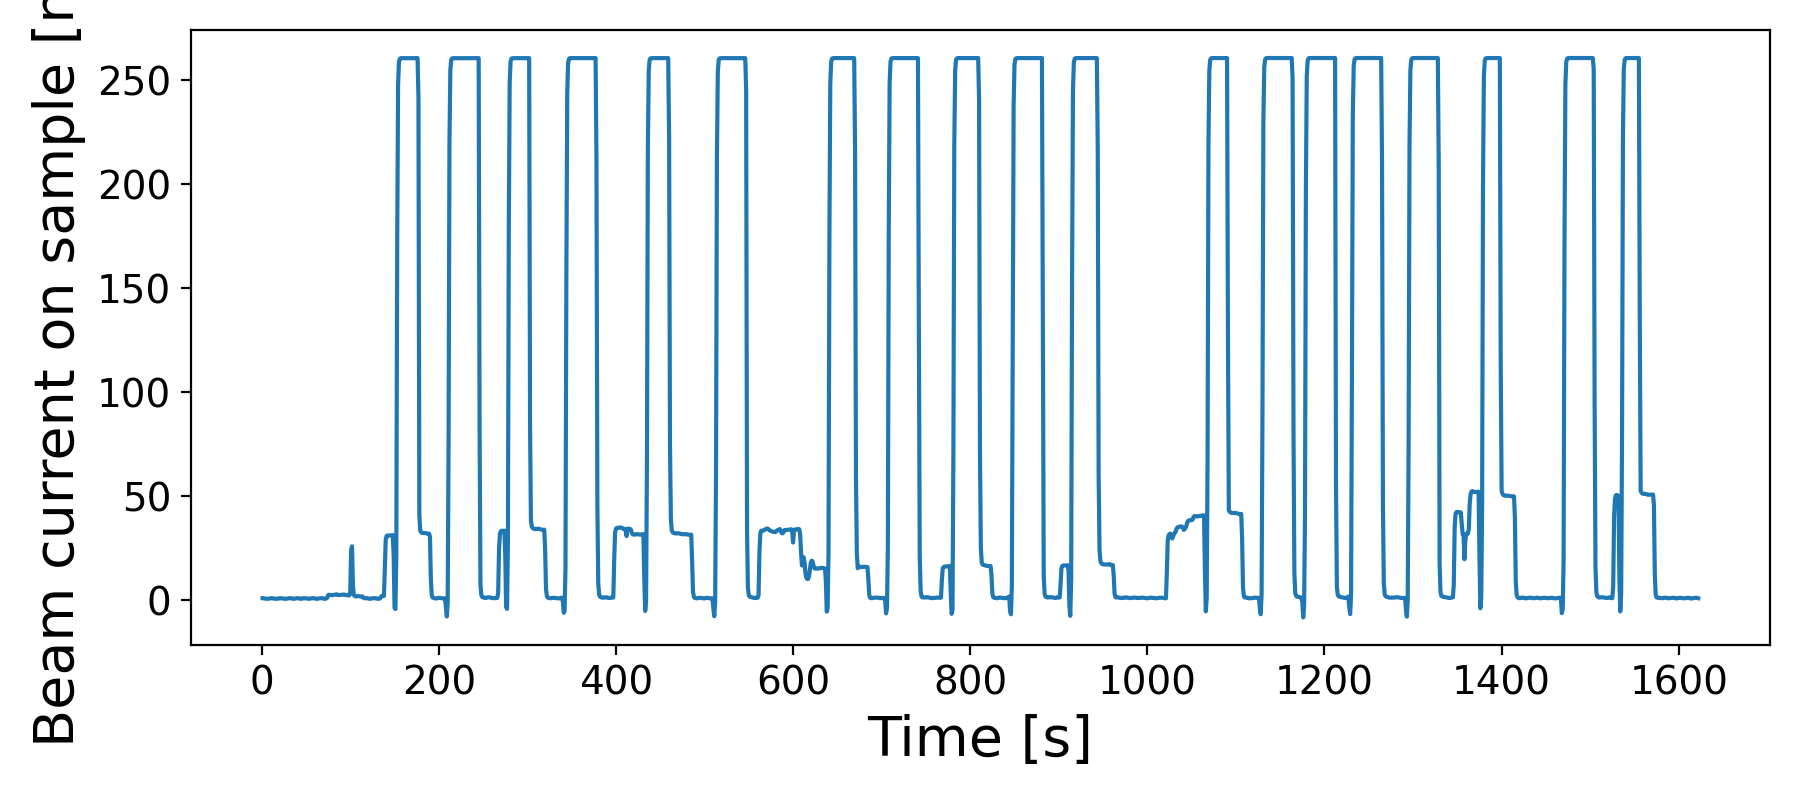

array([1.25412271e+18, 2.60625927e+18, 4.78747912e+18, 6.86522781e+18,
       7.55312046e+18, 8.32768960e+18, 1.08653979e+19, 1.33863657e+19,
       1.51968325e+19])

In [85]:
ibpath = '/Users/alexisdevitre/MIT Dropbox/Alexis Devitre/2020 PhD/Research/data/Fluence data/Proton_2025_03_27_Alexis_FFJ51.xlsx'
sname = 'beamon'
data = dose.loadBeamCurrent(ibpath, sname)

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(data.time_s, data.ibeam_nA)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Beam current on sample [nA]')
fig.tight_layout()

names = ['start', 'start_excluded', 'stop_excluded', 'stop', 'start_offset', 'stop_offset']
steps = pd.read_excel(ibpath, sheet_name='beamon', usecols=[5, 6, 7, 8, 9, 10], names=names, skiprows=1, nrows=9)

beamon_fluence_steps = []

for i, step in steps.iterrows():
    fluence, current = estimate_step_dose(data, step.start, step.start_excluded, step.stop_excluded, step.stop, step.start_offset, step.stop_offset, vb=False)
    beamon_fluence_steps.append(fluence)

path = 'ic/beamon/'
ics_beamon = hts.getIcT([path+f for f in np.sort(os.listdir(path)) if '0nA' in f])[2]
ics_nobeam = hts.getIcT([path+f for f in np.sort(os.listdir(path)) if ('0nA' not in f)&(f != '.DS_Store')])[2]

np.cumsum(beamon_fluence_steps)

## The temperature of the measurements between irradiation is not coherent, so we can only add the beam on fluence to the first fluence step as a correction.

<IPython.core.display.Javascript object>


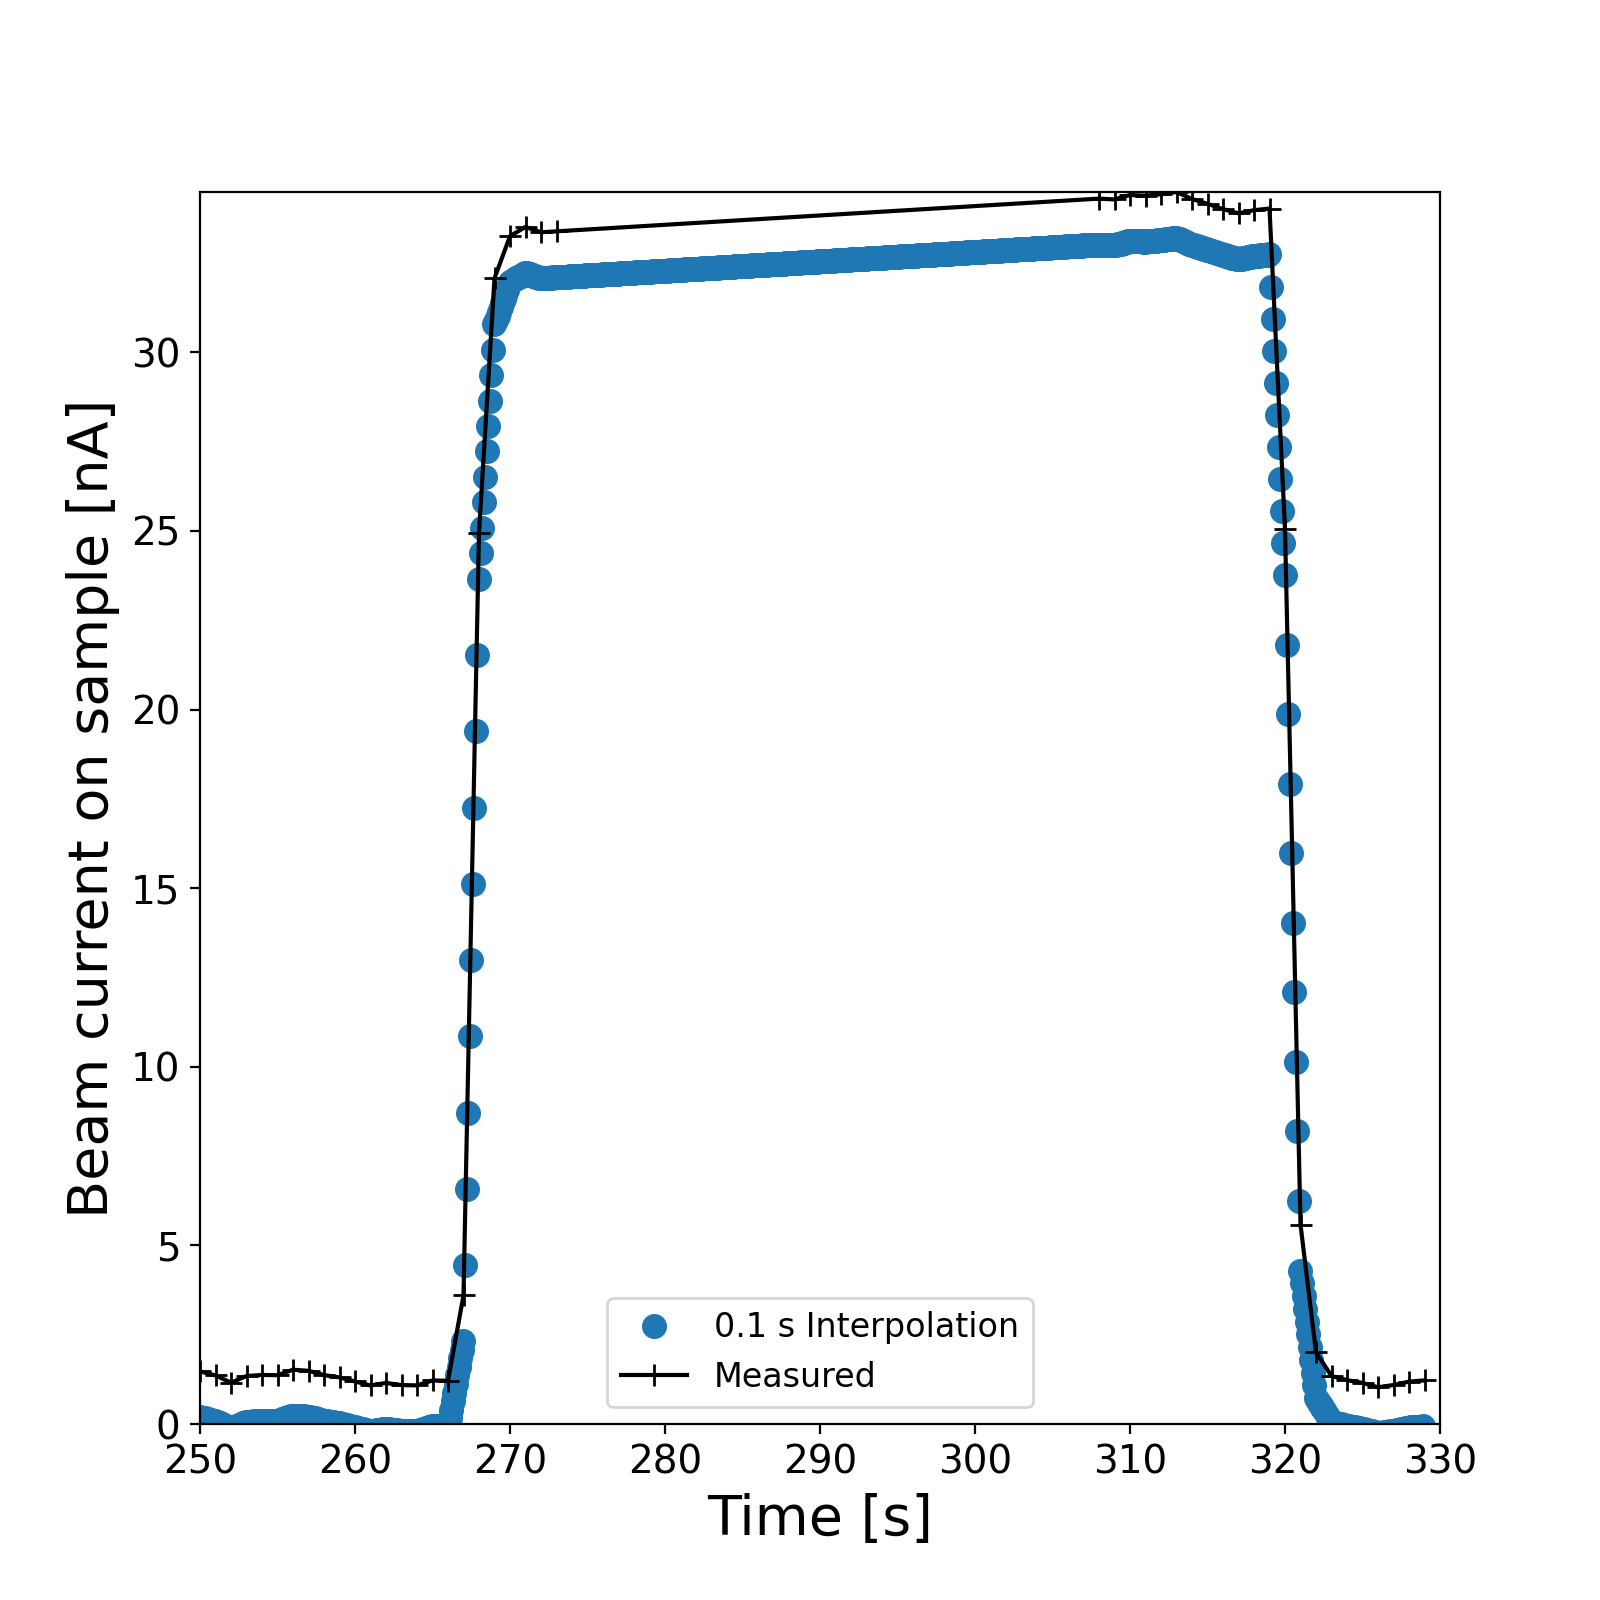

(1.3521365620074427e+18, 32.572081785714225)

In [43]:
data = dose.loadBeamCurrent(ibpath, sname)
t0, t1, t2, t3, to1, to2 = 250, 274, 308, 330, 250, 265

estimate_step_dose(data, t0, t1, t2, t3, to1, to2, vb=True)